In [190]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


# Notebook with EDA and process to Model Selection

## 1) EDA

The goal of the EDA is:
- look for any missing values in the data set
- look for eventual error measurements to be deleted or corrected (we dont necessarily pay very much attention to outliers because they are going to be many for a data set of this size)
- look which predictor variables might be useful to predict bike count 

Before starting the EDA, we remind the reader that the target variable (ie what we are trying to predict is the variable `log_bike_count`

We first import the original data, set check for missing values and error measurements and then merge it with the external and check no data was lost in the process

In [153]:
pd.set_option("display.precision", 2)  # set precision of outputs of our df

# read the data
df_original = pd.read_parquet(Path("data") / "train.parquet")
df_original.head()


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.00
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.69
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.00
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.85,2.38,1.61
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.85,2.38,2.30


In [154]:
df_original.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [155]:
df_original.describe()


,site_id,bike_count,latitude,longitude,log_bike_count
count,4.55e+05,455163.00,455163.00,455163.00,455163.00
mean,1.05e+08,59.48,48.85,2.35,3.05
std,3.16e+07,87.13,0.02,0.04,1.68
min,1.00e+08,0.00,48.83,2.27,0.00
25%,1.00e+08,4.00,48.84,2.31,1.61
50%,1.00e+08,28.00,48.85,2.35,3.37
75%,1.00e+08,79.00,48.86,2.38,4.38
max,3.00e+08,1275.00,48.89,2.41,7.15


There are 455 163 observations in the training data set and 9 predictor variables. However some of them like `site_name` and `site_id`, or `counter_name` and `counter_id` are redundant and both should not be included in the model. Also,  `site_id` is an int so we should remember it is a categorical variable if we want to use it in our model. <br>
Finally, there are no missing values. 
Let us now perform the merge and check how is the df.

In [156]:
file_path = Path("data") / "external_data.csv"
df_ext = pd.read_csv(file_path, parse_dates=["date"])


In [157]:
df_ext.head()


,Unnamed: 0.1,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,...,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2
0,0,0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
1,1,1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
2,2,2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,...,6.0,3.0,3000.0,NaN,NaN,NaN,True,True,False,False
3,3,3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
4,4,4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,...,7.0,6.0,810.0,NaN,NaN,NaN,True,True,False,False


In [158]:
np.unique(df_ext["numer_sta"])

array([7149], dtype=int64)

The weather data comes from one unique station, therefore this column is not needed we can drop it. <br>


In [159]:
# remove some unecessary columns

df_ext = df_ext.iloc[:,3:]


From the head, we already see that some columns seem to have a lot of missing values. We investigate this further. We also check first if there are duplicate rows and if any dates are missing.

In [167]:
df_ext[df_ext.duplicated()==True] 


,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2
2018,2020-11-20 18:00:00,103650,20,2,180,1.0,278.15,276.45,89,25000,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False


In [173]:
my_range = pd.date_range(
  start="2020-09-01", end="2021-10-18")

print(my_range.difference(df_ext['date']))

DatetimeIndex(['2021-01-17'], dtype='datetime64[ns]', freq=None)


One day is missing in the data set.

There is one duplicate row, we drop it.

In [169]:
df_ext = df_ext.drop_duplicates()

In [170]:
df_ext.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3321
Data columns (total 62 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3321 non-null   datetime64[ns]
 1   pmer         3321 non-null   int64         
 2   tend         3321 non-null   int64         
 3   cod_tend     3321 non-null   int64         
 4   dd           3321 non-null   int64         
 5   ff           3321 non-null   float64       
 6   t            3321 non-null   float64       
 7   td           3321 non-null   float64       
 8   u            3321 non-null   int64         
 9   vv           3321 non-null   int64         
 10  ww           3321 non-null   int64         
 11  w1           3314 non-null   float64       
 12  w2           3311 non-null   float64       
 13  n            3165 non-null   float64       
 14  nbas         3316 non-null   float64       
 15  hbas         2868 non-null   float64       
 16  cl    

In [179]:
print(df_ext.isnull().sum()[df_ext.isnull().sum() > 0])
print(
    f"there are {df_ext.isnull().sum()[df_ext.isnull().sum()>0].shape[0]} columns with at least 1 missing values ")

w1              7
w2             10
n             156
nbas            5
hbas          453
cl            413
cm           1381
ch           1644
niv_bar      3321
geop         3321
tend24         10
tn12         2492
tn24         3321
tx12         2492
tx24         3321
tminsol      3320
sw           3321
tw           3321
raf10          10
etat_sol       52
ht_neige       49
ssfrai        445
perssfrai     445
rr1             9
rr3             6
rr6            16
rr12           22
rr24           24
phenspe1     3321
phenspe2     3321
phenspe3     3321
phenspe4     3321
nnuage1       449
ctype1        798
hnuage1       455
nnuage2      1626
ctype2       1878
hnuage2      1626
nnuage3      2703
ctype3       2851
hnuage3      2703
nnuage4      3279
ctype4       3234
hnuage4      3279
dtype: int64
there are 44 columns with at least 1 missing values 


We have 44 columns with missing values.

Hence, we see that most columns have missing values and from the output, some columns have no non NA values! <br>
We drop the columns that have more than 10% missing values first as we are unlikely to be able to get interesting predictions with that little amount of data.


In [181]:
n_rows = df_ext.shape[0]

columns_to_drop = (df_ext.isnull().sum()/n_rows)[(df_ext.isnull().sum()/n_rows) > 0.1].index

df_ext = df_ext.drop(columns=columns_to_drop)



Let us check now the missing values again.

In [187]:

#df_merge_ext[df_merge_ext.isnull().sum()>0]
col_with_miss_values = df_ext.isnull().sum()[df_ext.isnull().sum() > 0].index
print(col_with_miss_values)

Index(['w1', 'w2', 'n', 'nbas', 'tend24', 'raf10', 'etat_sol', 'ht_neige',
       'rr1', 'rr3', 'rr6', 'rr12', 'rr24'],
      dtype='object')


There are 13 columns with missing values. How are these values missing, are they MCAR, MAR, or is there any pattern in the missing values?


We plot the missing values against time.

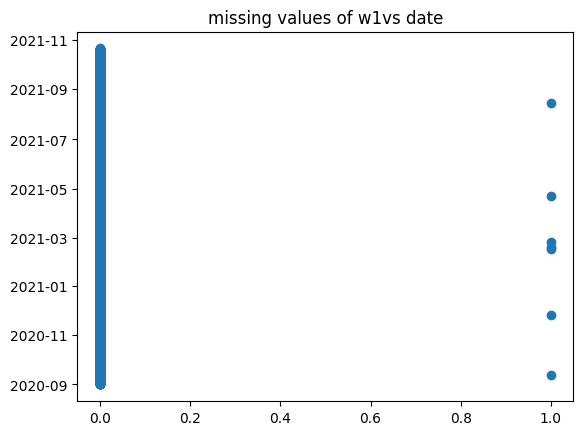

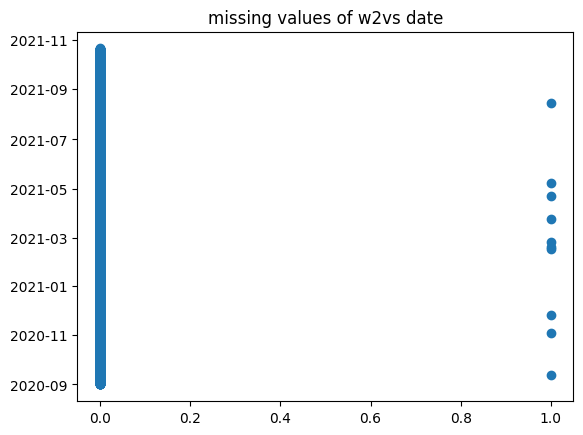

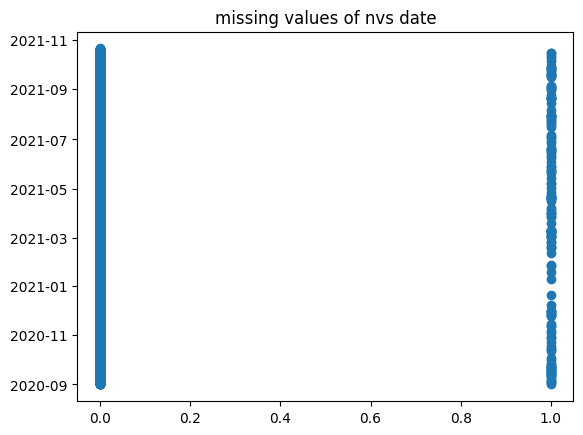

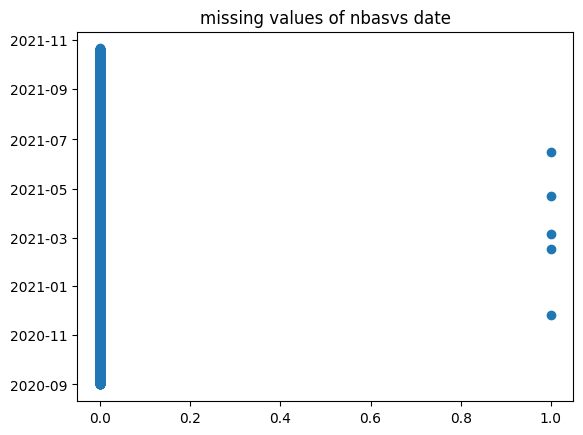

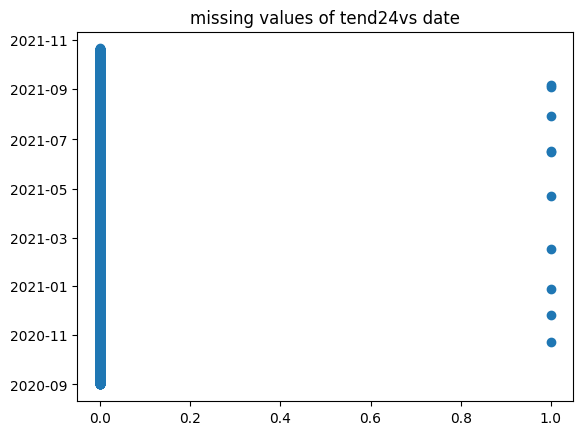

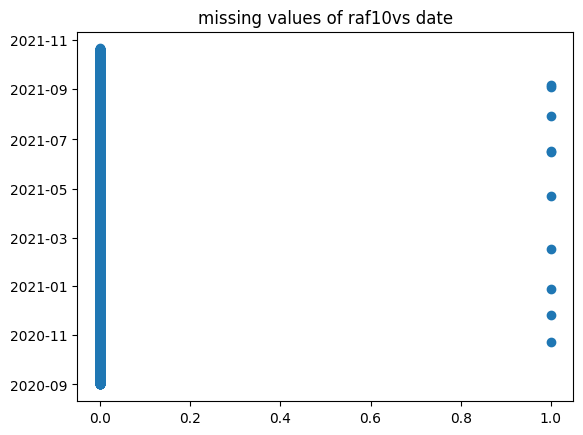

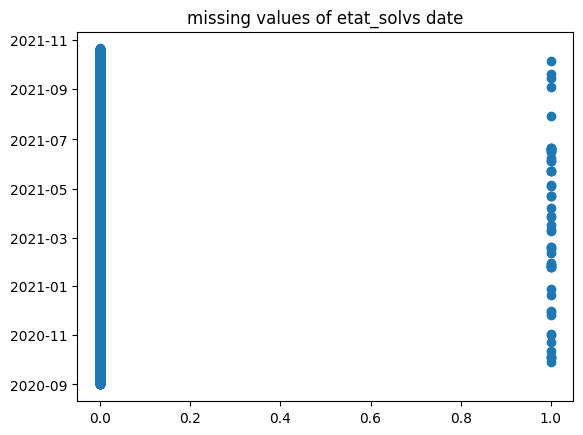

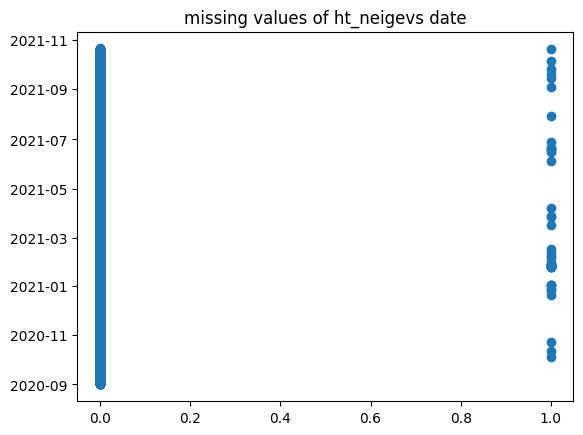

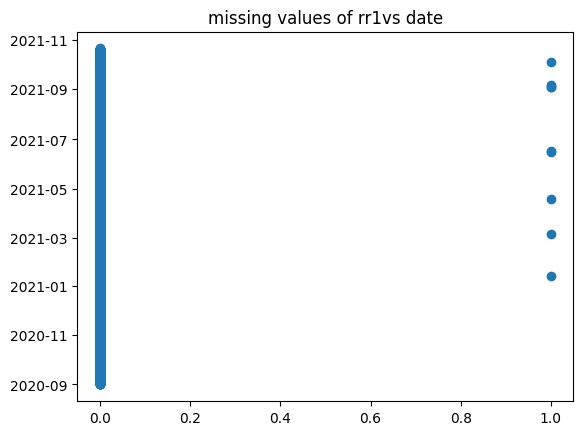

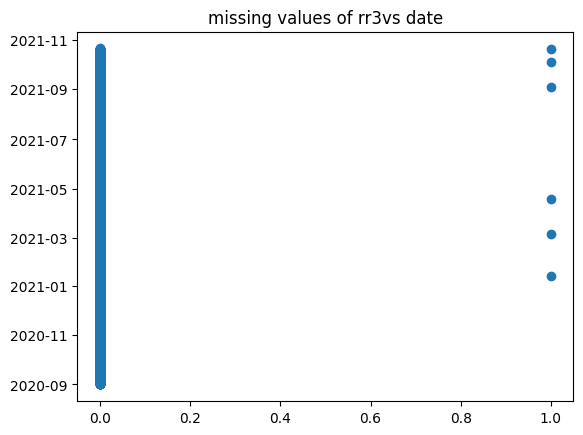

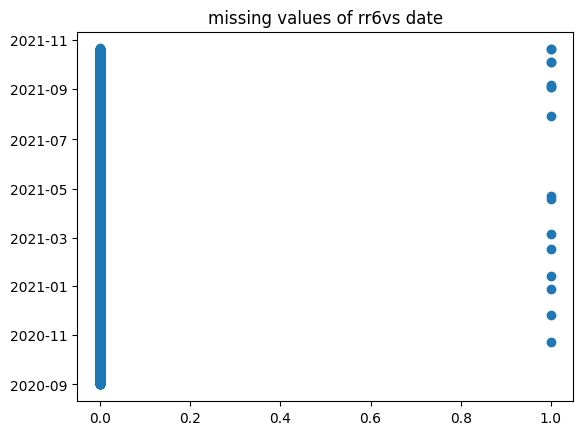

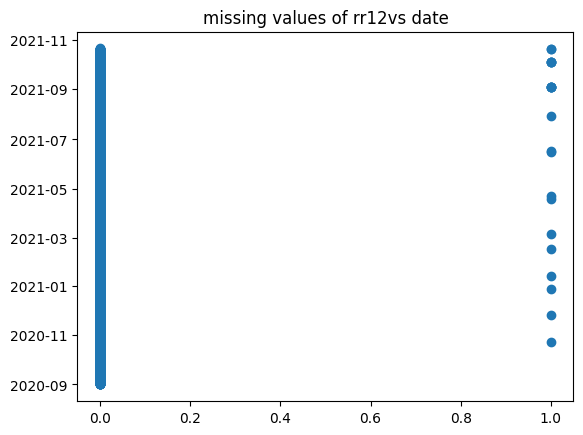

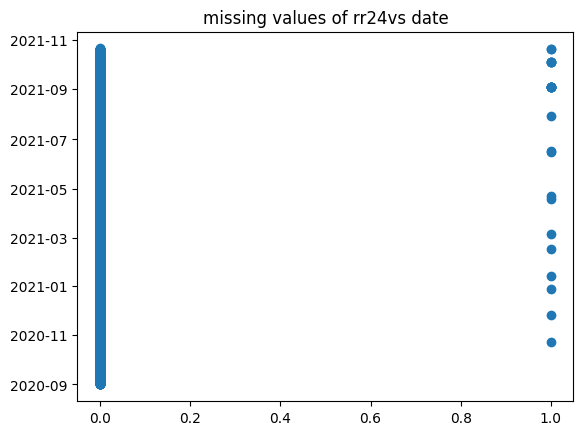

In [195]:
for el in col_with_miss_values:
    plt.scatter(df_ext[el].isnull(),df_ext["date"])
    plt.title("missing values of " + el + "vs date")
    plt.show()

In [196]:
# merge on date to obtain the full data set.

df_merge_ext = pd.merge_asof(df_original.sort_values(
    "date"), df_ext.sort_values("date"), on="date")


## 2) Model Selection

In [31]:
def _merge_external_data(X):
    file_path = Path("data") / "external_data.csv"
    df_ext = pd.read_csv(file_path, parse_dates=["date"])

    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(  # , "nbas" , "raf10"
        X.sort_values("date"), df_ext[["date", "hol_bank", "hol_scol", "quarantine1", "quarantine2", "t", "rr1", "u", "nbas", "raf10"]].sort_values("date").dropna(), on="date")  # , direction="nearest"
    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X


def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    X.loc[:, "weekend"] = X["weekday"] > 4

    X['sin_hours'] = np.sin(2*np.pi*X["hour"]/24)
    X['cos_hours'] = np.cos(2*np.pi*X["hour"]/24)

    X['sin_mnth'] = np.sin(2*np.pi*X["month"]/12)
    X['cos_mnth'] = np.cos(2*np.pi*X["month"]/12)

    return X.drop(columns=["date"])


First we create a function to easily get the different features we want to test.
We get:
- the features that do not need to be preprocessed 
- the categorical features that need 1-0 encoding

In [32]:
# function to get the features that do not need to be processed
def get_passthrough(date, list_of_temp):
    """function to get the features that will not be transformed at the prepocessing stage

    Args:
        date (str): "both_date": select all the date features                   
                    "original_date": selecte date without sin transformed
                    "transformed_date": select date with sin-cos transformation

        list_of_temp (list): list of features (no date) that will not be transformed

    Returns:
        _type_: features to not be transformed  
    """
    pass_through_cols = []
    if "both_date" == date:
        pass_through_cols = ["hour", "day", "weekday", "month",
                             "year", "sin_hours", "cos_hours", "sin_mnth", "cos_mnth"]

    if "original_date" == date:
        pass_through_cols = ["hour", "day", "weekday", "month", "year"]

    if "transformed_date" == date:
        pass_through_cols = ["sin_hours", "cos_hours",
                             "sin_mnth", "cos_mnth", "year", "weekday"]

    for el in list_of_temp:
        pass_through_cols.append(el)

    return pass_through_cols


In [33]:
def get_estimator(pass_through_cols, categorical_cols, regressor=XGBRegressor()):

    # define the encoders
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    date_encoder = FunctionTransformer(_encode_dates)

    # define the transformation of data before using regressor
    preprocessor = ColumnTransformer(
        [
            ("cat", categorical_encoder, categorical_cols),
            # ("std_scaler", StandardScaler(), numerical_cols),
            ("passthrough", "passthrough", pass_through_cols)
        ],
    )

    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder,
        preprocessor,
        regressor,
    )

    return pipe


In [34]:
# test
a = ["sin_hours", "cos_hours", "sin_mnth", "cos_mnth"]
b = ["counter_name", "site_name", "weekday", "weekend"]
model = get_estimator(a, b, regressor=Ridge())
model


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000016C895DF040>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x0000016CFFE60B80>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'weekday', 'weekend']),
                                                 ('passthrough', 'passthrough',
                                                  ['sin_hours', 'cos_hours',
                                                   'sin_mnth', 'cos_mnth'])])),
                ('ridge', Ridge())])

In [35]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()


model.fit(X_train, y_train)


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000016C895DF040>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x0000016CFFE60B80>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'weekday', 'weekend']),
                                                 ('passthrough', 'passthrough',
                                                  ['sin_hours', 'cos_hours',
                                                   'sin_mnth', 'cos_mnth'])])),
                ('ridge', Ridge())])

In [36]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}"
)


Train set, RMSE=0.97
Test set, RMSE=0.91


In [44]:
def test_model(pass_throughs_col, categorical_cols, regressor = XGBRegressor(max_depth = 4, subsample = 0.8)):
    """test a model given the features and the regressor and output the prediction on the test data set and the scores on train and test

    Args:
        pass_throughs_col (list): list of features not to be transform during pre-processing step
        categorical_cols (list): columns to be one hot encoded
        regressor (regressor to use in our model, optional): scikit compatible function. Defaults to XGBRegressor().

    Returns:
        array,float,float: the prediction on the test set, the score on the training set, the score on the testing set
    """
    X_train, y_train = problem.get_train_data()
    X_test, y_test = problem.get_test_data()    
    model = get_estimator(pass_throughs_col,categorical_cols,regressor)
    model.fit(X_train, y_train)

    return model.predict(X_test), mean_squared_error(y_train, model.predict(X_train)), mean_squared_error(y_test, model.predict(X_test), squared=False)

    

Now that we have our functions to test different models quickly, we are going to try some different models using linear regression and Xgboost and compare the RMSE. Because XGboost tends to overfitt, we are going to limit the complexity of our model to an arbitrary threshold.<br>
We are going to test:
- the minimum model with date not transformed and no external data added
- min model with date transformed (we dont use both dates as it is redundant)
- min model with weather 
- min model with quarantine 
- min model with holidays

Then we are going to try different combination of the above models.

In [40]:
list_of_pass = []


(array([0.9956349, 0.8084573, 0.5862392, ..., 2.8172295, 2.0996752,
        2.1578777], dtype=float32),
 0.2622444198076327,
 0.4306174323636791)